In [107]:
import pandas as pd
import numpy as np
from pyproj import Proj, transform
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib 
import folium
from matplotlib import font_manager, rc
import platform
import json

%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
elif platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Linux':
    rc('font', family='NanumBarunGothic')
else:
    print('Unknown system... sorry~~')
    
pd.set_option('display.max_row', 100)
pd.set_option('display.max_columns', 100)

In [6]:
# 소비력있는 제주도민이 거주하는 지역과 관광객이 주로 숙박하는 호텔이 위치하는 지역을 합친 데이터프레임
merge_df = pd.concat([df, jeju_a_lv], axis=0)
merge_df.reset_index(inplace=True, drop=True)
merge_df

,x,y,name
0,126.604286,33.241092,a
1,126.897845,33.402648,a
2,126.522387,33.244210,a
3,126.709468,33.472091,a
4,126.562333,33.244088,a
...,...,...,...
186,126.545353,33.502651,b
187,126.712843,33.551262,b
188,126.491201,33.254887,b
189,126.491201,33.254887,b


In [7]:
# 위도,경도 값을 실제 주소로 변환
# api key 호출
def get_secretKeys():
    
    file = open("../keys/secret_keys.txt", "rt")
    split_keys = []
    line_count = 0
    
    load_datas = file.readlines()
    
    file.close()
    
    for i in range(len(load_datas)):
        split_keys.append(load_datas[i].split('=')[1].replace('"', ""))
    
    return split_keys


# api 요청 url 생성
def get_search_url(req_x, req_y):
    
    api_list = get_secretKeys()
    
    base = "https://dapi.kakao.com/v2/local/geo/coord2regioncode.json"     
    header_phrase = "KakaoAK"
    api_key = api_list[1] 
    
    
    headers = {"Authorization": header_phrase + api_key[1:]} # api_key[1:] = 공백 제거
    
    req_lat = "?x=" + str(req_x)
    req_lng = "&y=" + str(req_y)
    
    url = base + req_lat + req_lng
    req_set = (url, headers)
    
    return req_set


def get_result(url, header):
    
    req = requests.get(url, headers=header)
    res = json.loads(req.text)
     
    return res


# 변환된 위도,경도를 주소로 요청
def reverse_geocoding(req_x, req_y):

    req_set = get_search_url(req_x, req_y)
    res_api = get_result(req_set[0], req_set[1])
    
    return res_api


# reverse geocoding start
proj_x = [merge_df['x'].tolist()]
proj_y = [merge_df['y'].tolist()]

res_json = []

for i in range(len(proj_x[0])):
    try:
        raw_res_json = reverse_geocoding(proj_x[0][i], proj_y[0][i])
        res_json.append(raw_res_json['documents'][0]['region_3depth_name'])
    except:
        res_json.append('')

        
merge_df['Dong'] = res_json
merge_df.tail(3)

,x,y,name,Dong
188,126.491201,33.254887,b,강정동
189,126.491201,33.254887,b,강정동
190,126.533893,33.501538,b,이도이동


In [8]:
# a(관광객 숙박) + b(제주도민 거주) 상위 동
dong_count = merge_df.groupby(['Dong']).count()
dong_count.iloc[:,-1:].sort_values(by='name', ascending=False)

,name
Dong,
성산읍,16
남원읍,14
애월읍,14
연동,11
한림읍,10
안덕면,8
이도이동,8
조천읍,8
구좌읍,7


### 성산읍, 남원읍, 애월읍, 연동, 한림읍, 안덕면, 이도이동, 조천읍의 업종 비교
- 제주시, 서귀포시 오전 10시 ~ 오후 10시 사이 '영세' 음식점업, 소매업 중 총 소비금액 기준 상위 업종

In [2]:
data_url = '../datas/detailed_consume_type_data.csv'
consume_data = pd.read_csv(data_url, sep=',')
jejusi_consume = consume_data[consume_data['Sigungu'] == '제주시']
jejusi_consume.reset_index(drop=True, inplace=True)

# x시 제거
drop_target = jejusi_consume[jejusi_consume['Time']=='x시'].index.tolist()
jejusi_consume = jejusi_consume.drop(index=drop_target)
jejusi_consume.tail(3)

,YM,Sido,Sigungu,FranClass,Type,Time,TotalSpent,DisSpent,NumofSpent,NumofDisSpent,POINT_X,POINT_Y,LargeCategory,MediumCategory
191449,202005,제주특별자치도,제주시,중소,편의점,23시,106200,0,10,0,949566.1569,1502604.267,소매업,체인화 편의점
191450,202005,제주특별자치도,제주시,영세,스넥,23시,200800,0,7,0,949616.8571,1502454.567,음식점업,"피자, 햄버거, 샌드위치 및 유사 음식점업"
191451,202005,제주특별자치도,제주시,영세,일반한식,23시,120000,0,2,0,950674.5989,1500760.286,음식점업,한식 음식점업


In [3]:
# 제주시 내 10시 ~ 22시 사이 결제 + 영세 + '소매업', '음식점업' TotalSpent 기준 상위 업종 13개 기준
jejusi_url = '../datas/detailed_consume_type_jejusi.csv'
jejusi_data = pd.read_csv(jejusi_url, sep=',')

# 서귀포시 내 10시 ~ 22시 사이 결제 + 영세 + '소매업', '음식점업' TotalSpent 기준 상위 업종 13개 기준
seogwiposi_url = '../datas/detailed_consume_type_seogwipo.csv'
seogwiposi_data = pd.read_csv(seogwiposi_url, sep=',')

In [4]:
# 제주시 + 서귀포시 데이터
jeju_data = pd.concat([jejusi_data, seogwiposi_data], axis=0)
jeju_data = jeju_data.iloc[:, 4:]
jeju_data.reset_index(drop=True, inplace=True)
len(jeju_data)

86582

In [133]:
# 소비력있는 제주도민이 주로 거주하는 동네 + 관광객이 주로 묵는 호텔이 위치한 읍,면,동 top 8
top_dong = ['성산읍', '남원읍', '애월읍', '연동', '한림읍', '안덕면', '이도이동', '조천읍']
top_dong_df = jeju_data[jeju_data['Dong'].isin(top_dong)]
top_dong_df.reset_index(drop=True, inplace=True)
top_dong_df.tail(2)

,Sigungu,FranClass,Type,Time,TotalSpent,DisSpent,NumofSpent,NumofDisSpent,POINT_X,POINT_Y,LargeCategory,MediumCategory,Proj_X,Proj_Y,Dong
28706,서귀포시,영세,일반한식,13시,50000,30000,2,1,894968.4998,1475453.828,음식점업,한식 음식점업,126.370156,33.268103,안덕면
28707,서귀포시,영세,일반한식,13시,427000,0,10,0,895946.0817,1480056.477,음식점업,한식 음식점업,126.380121,33.309706,안덕면


#### 소비력이 있는 관광객 숙박지역 + 제주도민 거주 지역별 총 소비횟수, 총 소비금액 비교

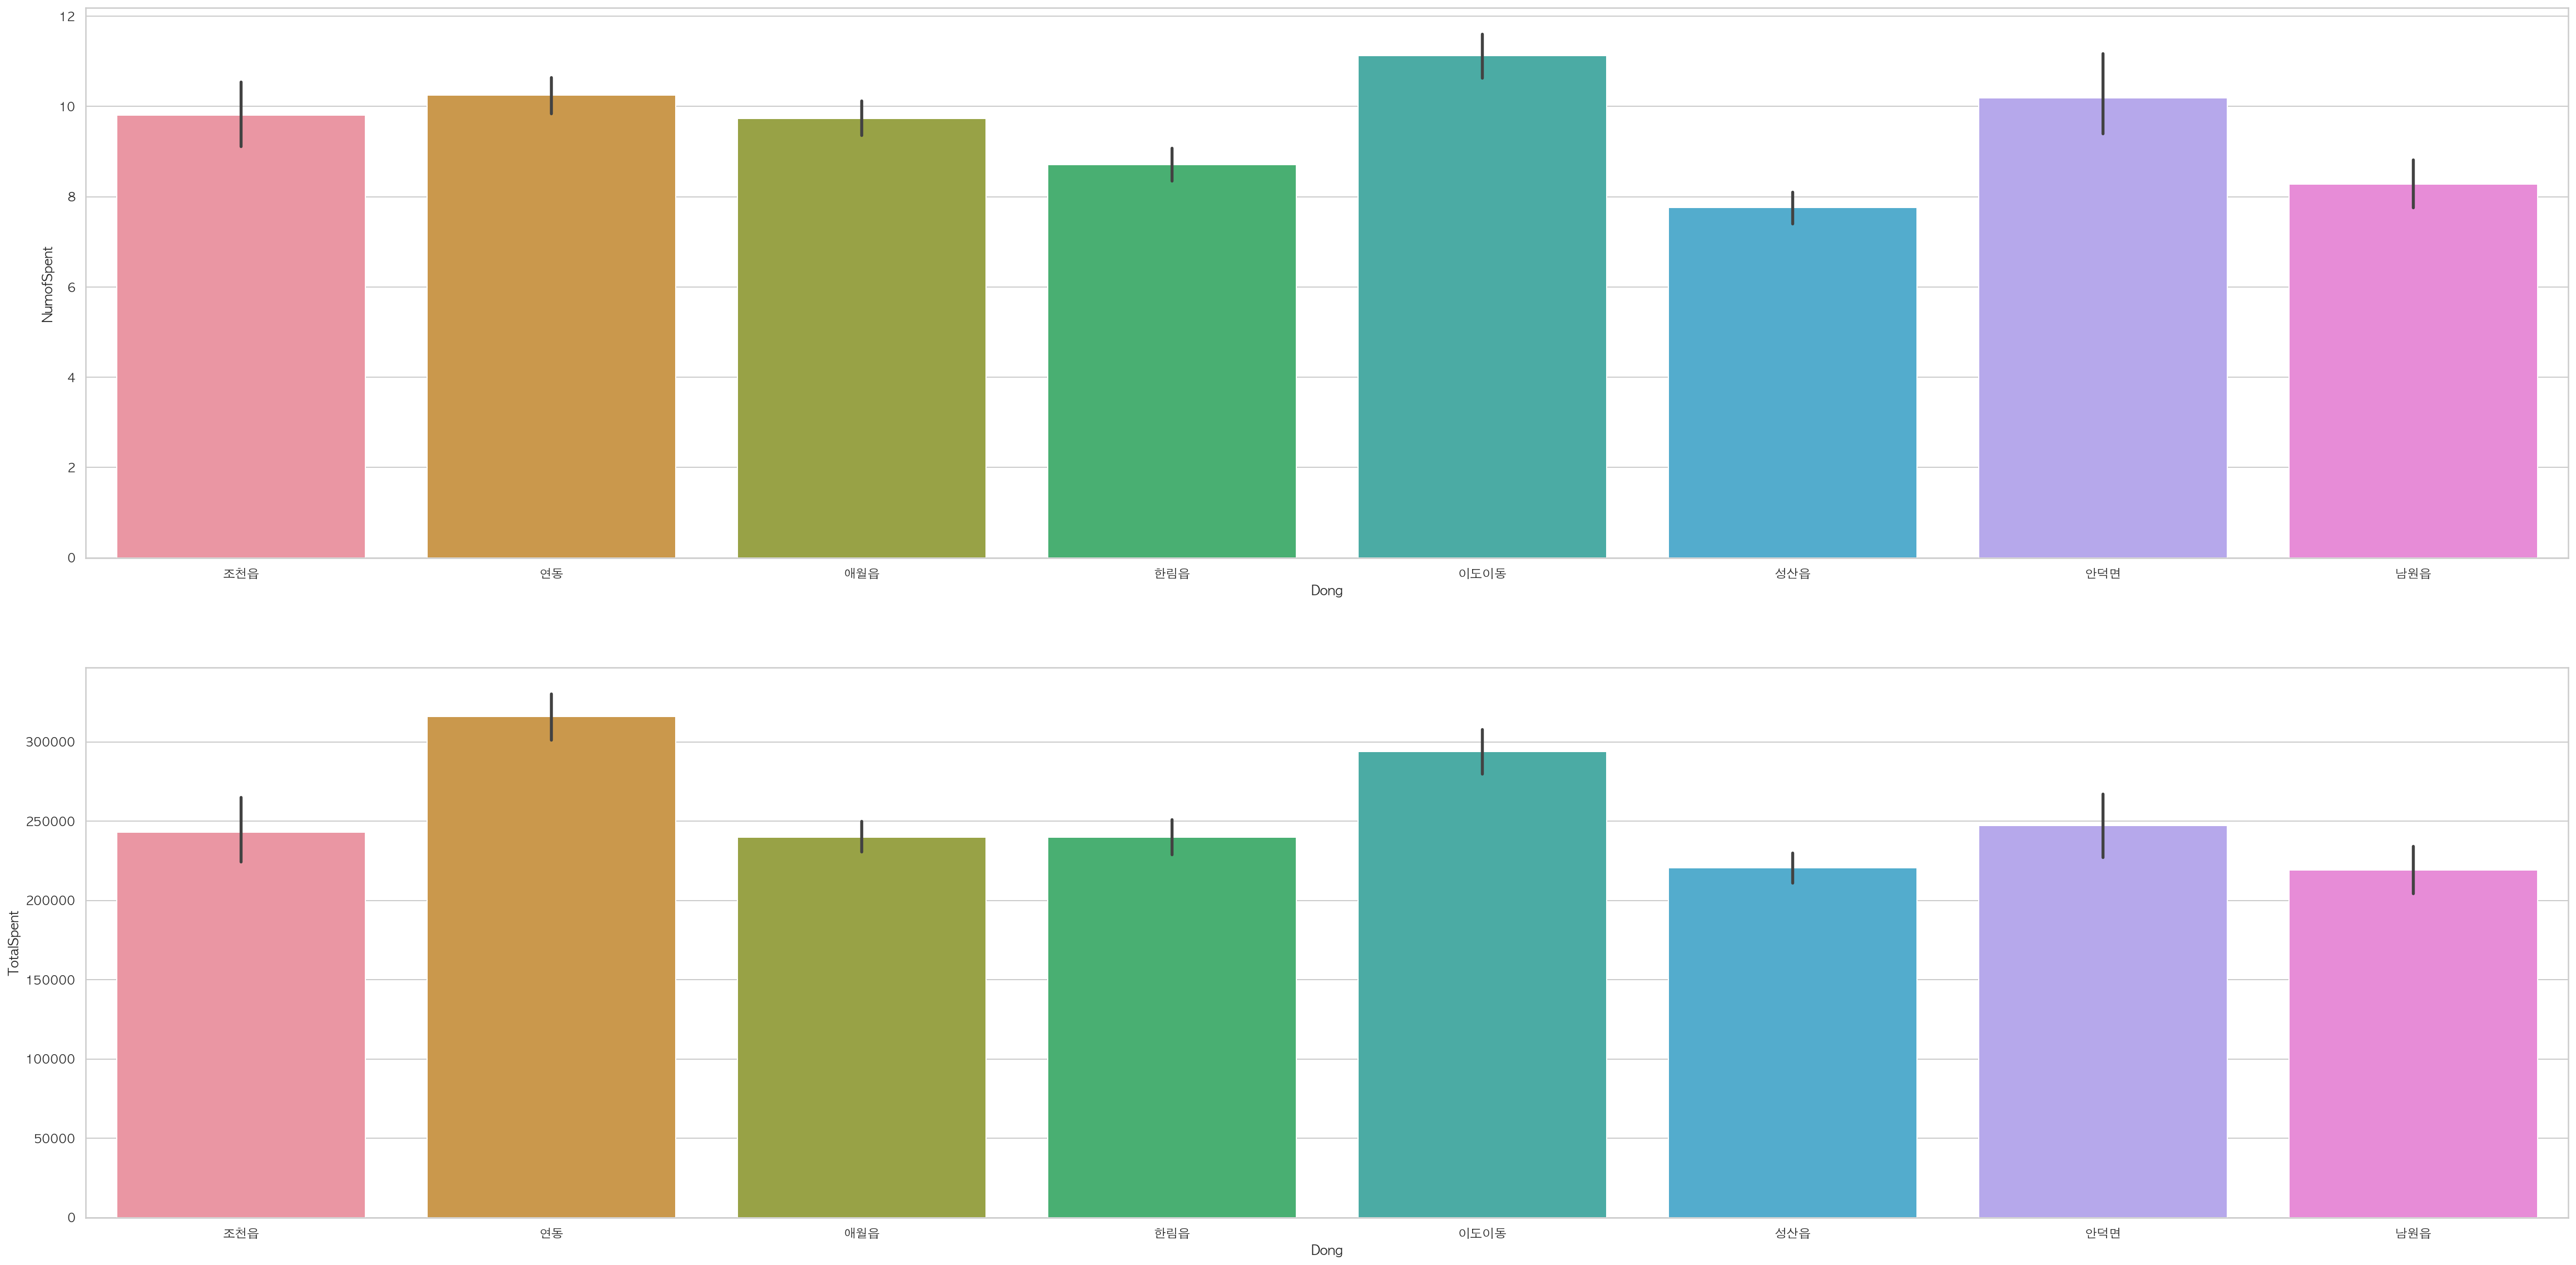

In [6]:
# top 8 읍,면,동 NumofSpent, TotalSpent
sns.set(rc={'axes.unicode_minus':False}, font='AppleGothic', style='whitegrid')
fig, axes = plt.subplots(2,1, figsize=(40,20))
sns.set_palette('Greens', 3)

sns.barplot(ax=axes[0], x='Dong', y='NumofSpent', data=top_dong_df)
sns.barplot(ax=axes[1], x='Dong', y='TotalSpent', data=top_dong_df)
plt.show()

#### 매출 Top 10 업종
- 일반한식, 서양음식, 스넥, 편의점, 농축수산품, 슈퍼마켓, 중국음식, 정장, 기타음료식품, 주점	

In [7]:
# 매출 Top 10 업종
type_count = top_dong_df.groupby(['Type']).count()
type_count = type_count[['TotalSpent', 'NumofSpent', 'Dong']].sort_values(by='NumofSpent', ascending=False)[:10]
type_count

,TotalSpent,NumofSpent,Dong
Type,,,
일반한식,12655,12655,12655
서양음식,4995,4995,4995
스넥,1563,1563,1563
편의점,1251,1251,1251
농축수산품,1152,1152,1152
슈퍼마켓,853,853,853
중국음식,756,756,756
정장,730,730,730
기타음료식품,722,722,722


In [8]:
# top 8 읍,면,동 지역의 매출 top 10 업종
type_10 = type_count.sort_values(by='NumofSpent', ascending=False)[:10].index.tolist()

top_type_df = top_dong_df[top_dong_df['Type'].isin(type_10)]
top_type_df.reset_index(drop=True, inplace=True)
top_type_df.tail(2)

,Sigungu,FranClass,Type,Time,TotalSpent,DisSpent,NumofSpent,NumofDisSpent,POINT_X,POINT_Y,LargeCategory,MediumCategory,Proj_X,Proj_Y,Dong
25261,서귀포시,영세,일반한식,13시,50000,30000,2,1,894968.4998,1475453.828,음식점업,한식 음식점업,126.370156,33.268103,안덕면
25262,서귀포시,영세,일반한식,13시,427000,0,10,0,895946.0817,1480056.477,음식점업,한식 음식점업,126.380121,33.309706,안덕면


#### Top 10 업종의 총 소비횟수, 총 소비금액 비교

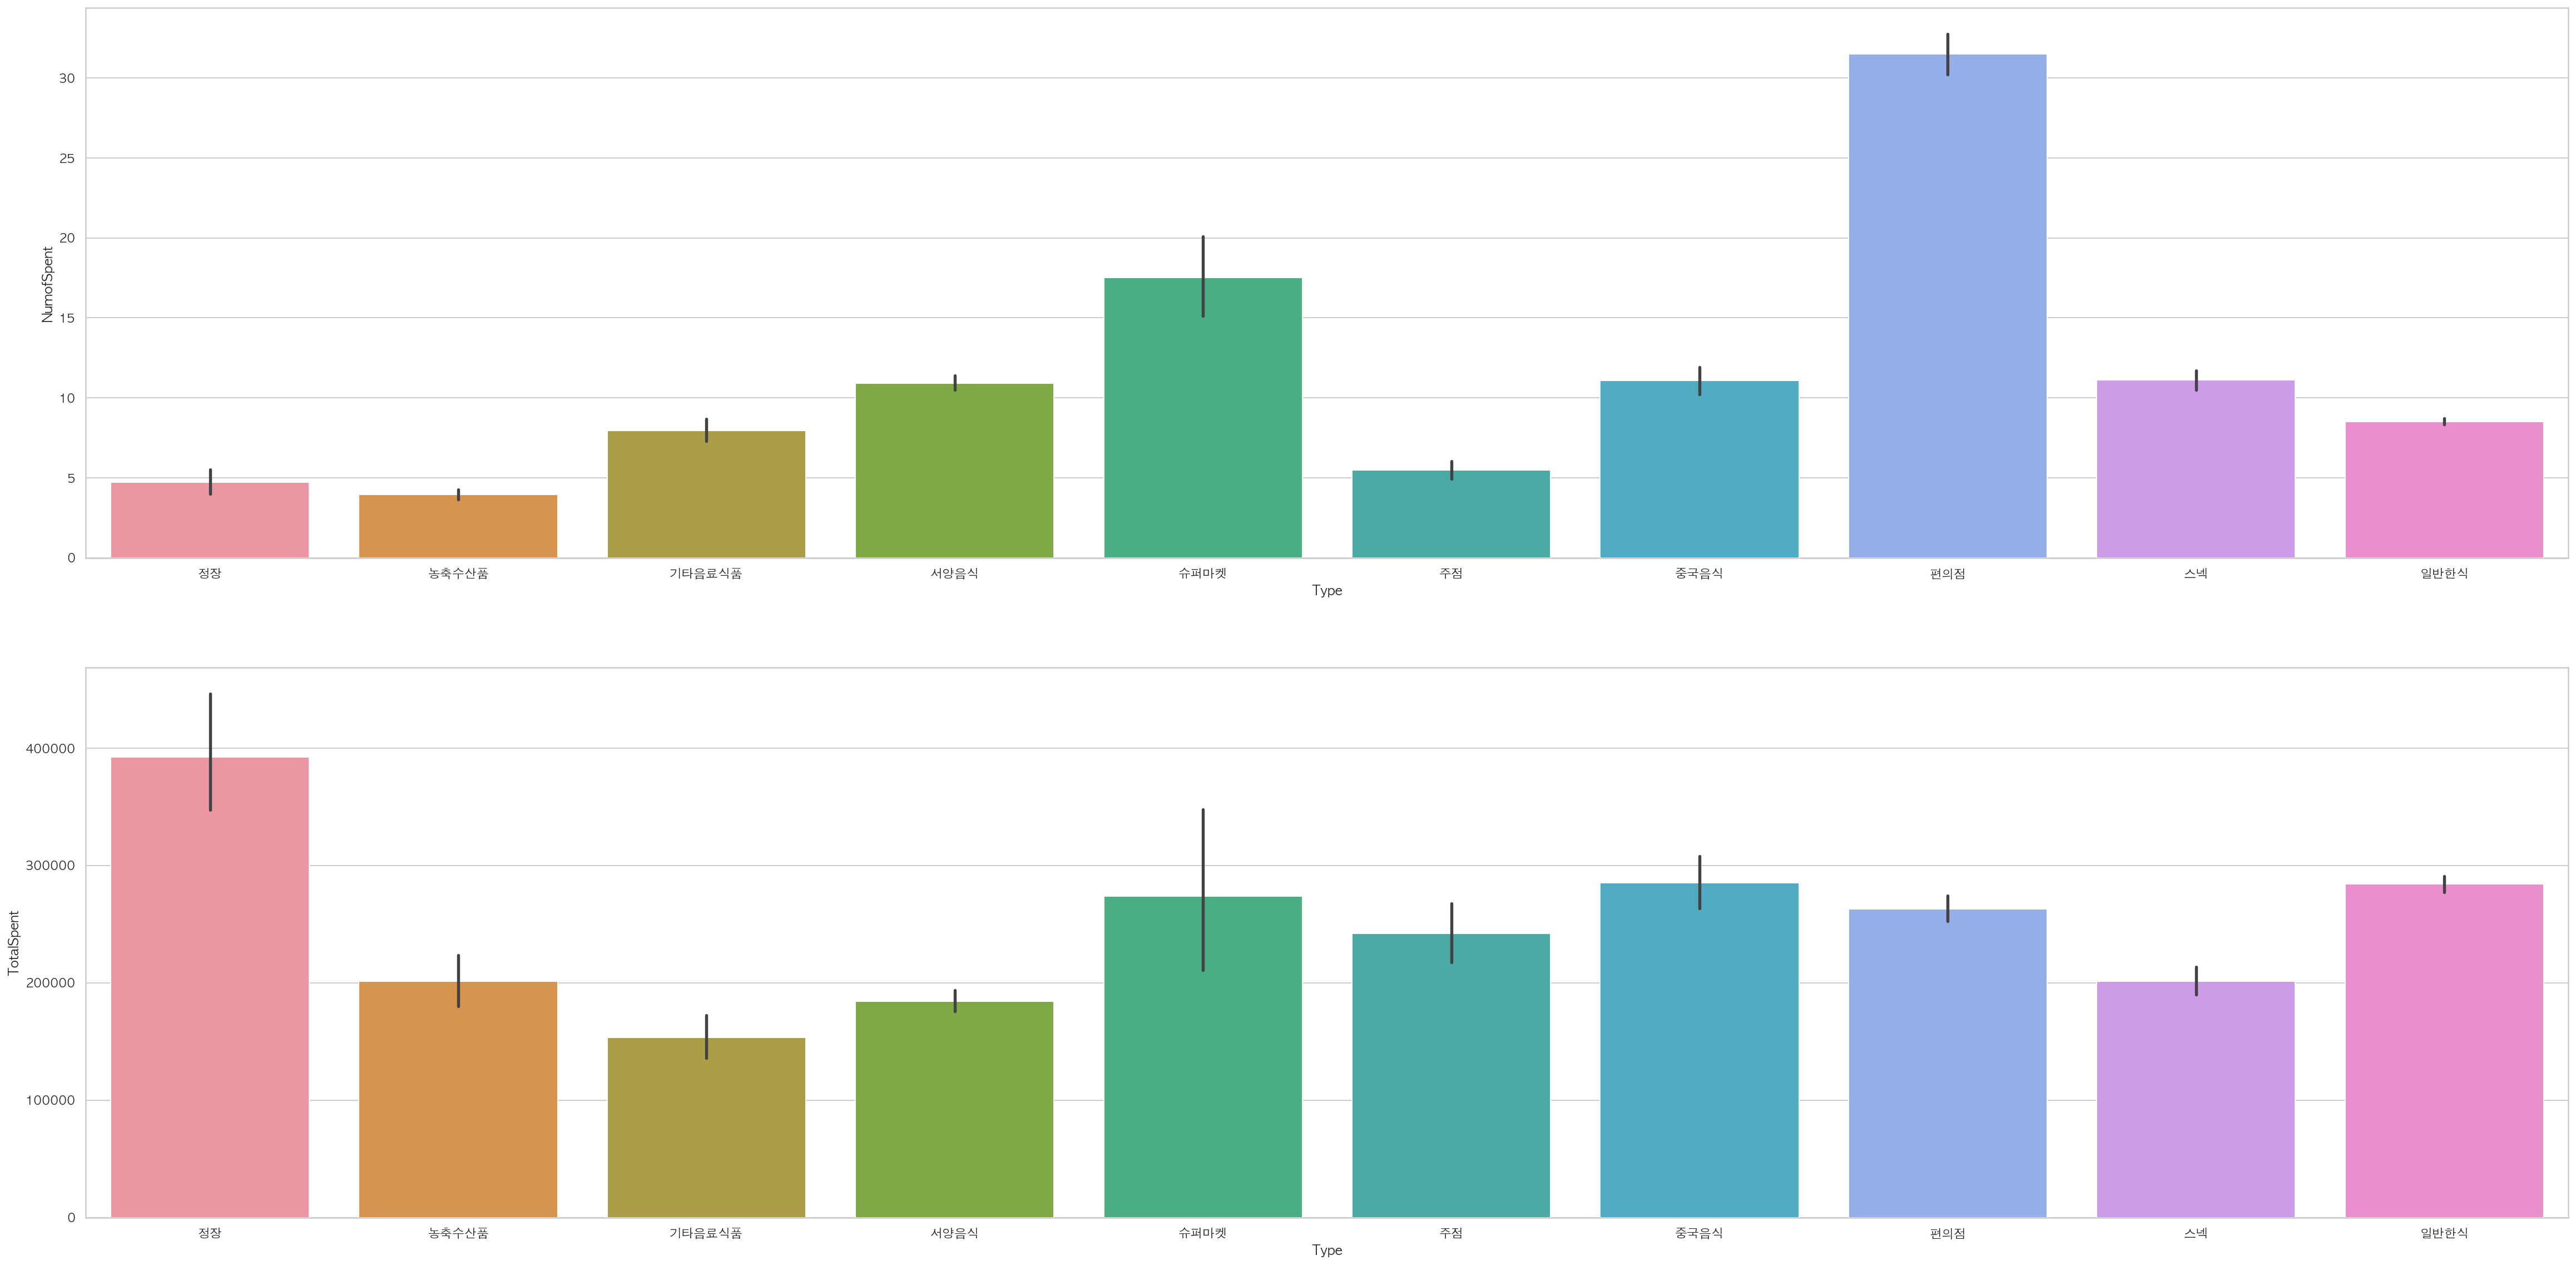

In [9]:
# top 8 읍,면,동 지역의 top 10 업종별 소비횟수, 총 매출액
sns.set(rc={'axes.unicode_minus':False}, font='AppleGothic', style='whitegrid')
fig, axes = plt.subplots(2,1, figsize=(40,20))
sns.set_palette('Greens', 3)

sns.barplot(ax=axes[0], x='Type', y='NumofSpent', data=top_type_df)
sns.barplot(ax=axes[1], x='Type', y='TotalSpent', data=top_type_df)
plt.show()

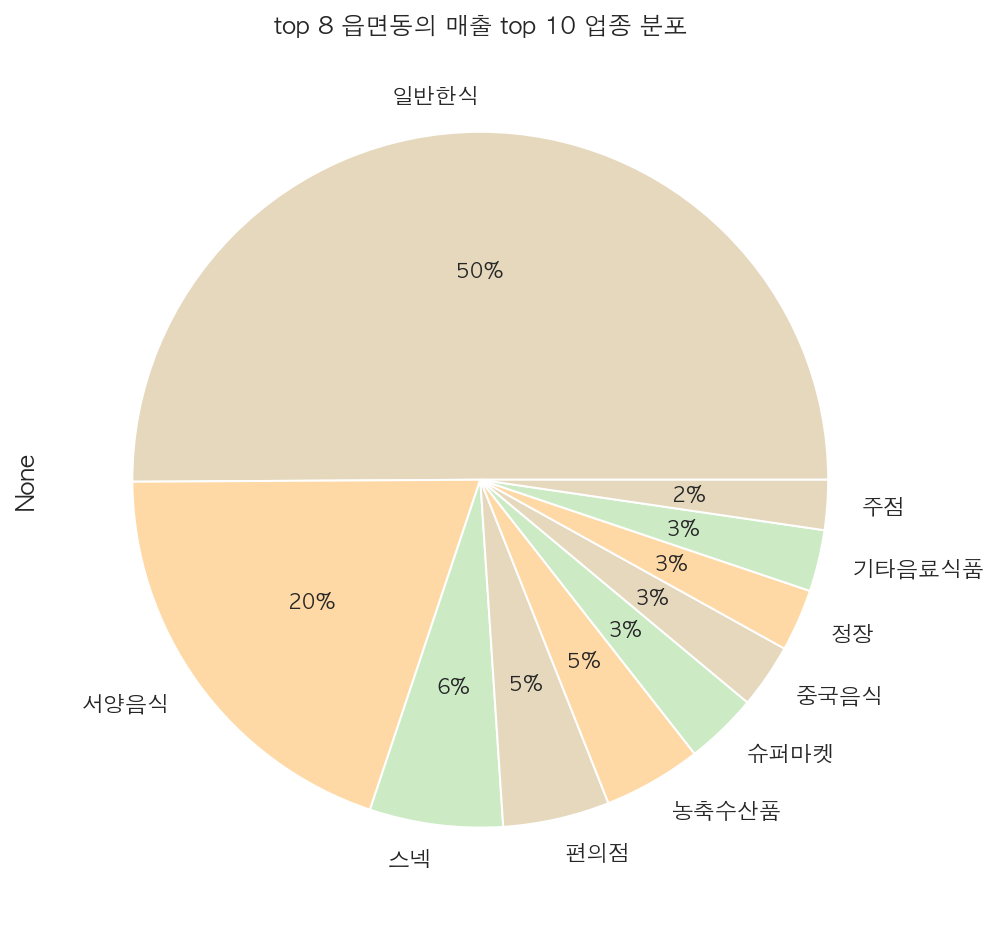

In [134]:
# 업종 분포
fig, axes = plt.subplots(1,1, figsize=(8,8))
sns.set_palette('Pastel1_r', 3)

top_type_df.Type.str.split('|', expand=True).stack().value_counts().plot(kind='pie', title='top 8 읍면동의 매출 top 10 업종 분포', autopct='%1.0f%%')
plt.show()

#### 지역별 비교
- '성산읍', '남원읍', '애월읍', '연동', '한림읍', '안덕면', '이도이동', '조천읍' 기준

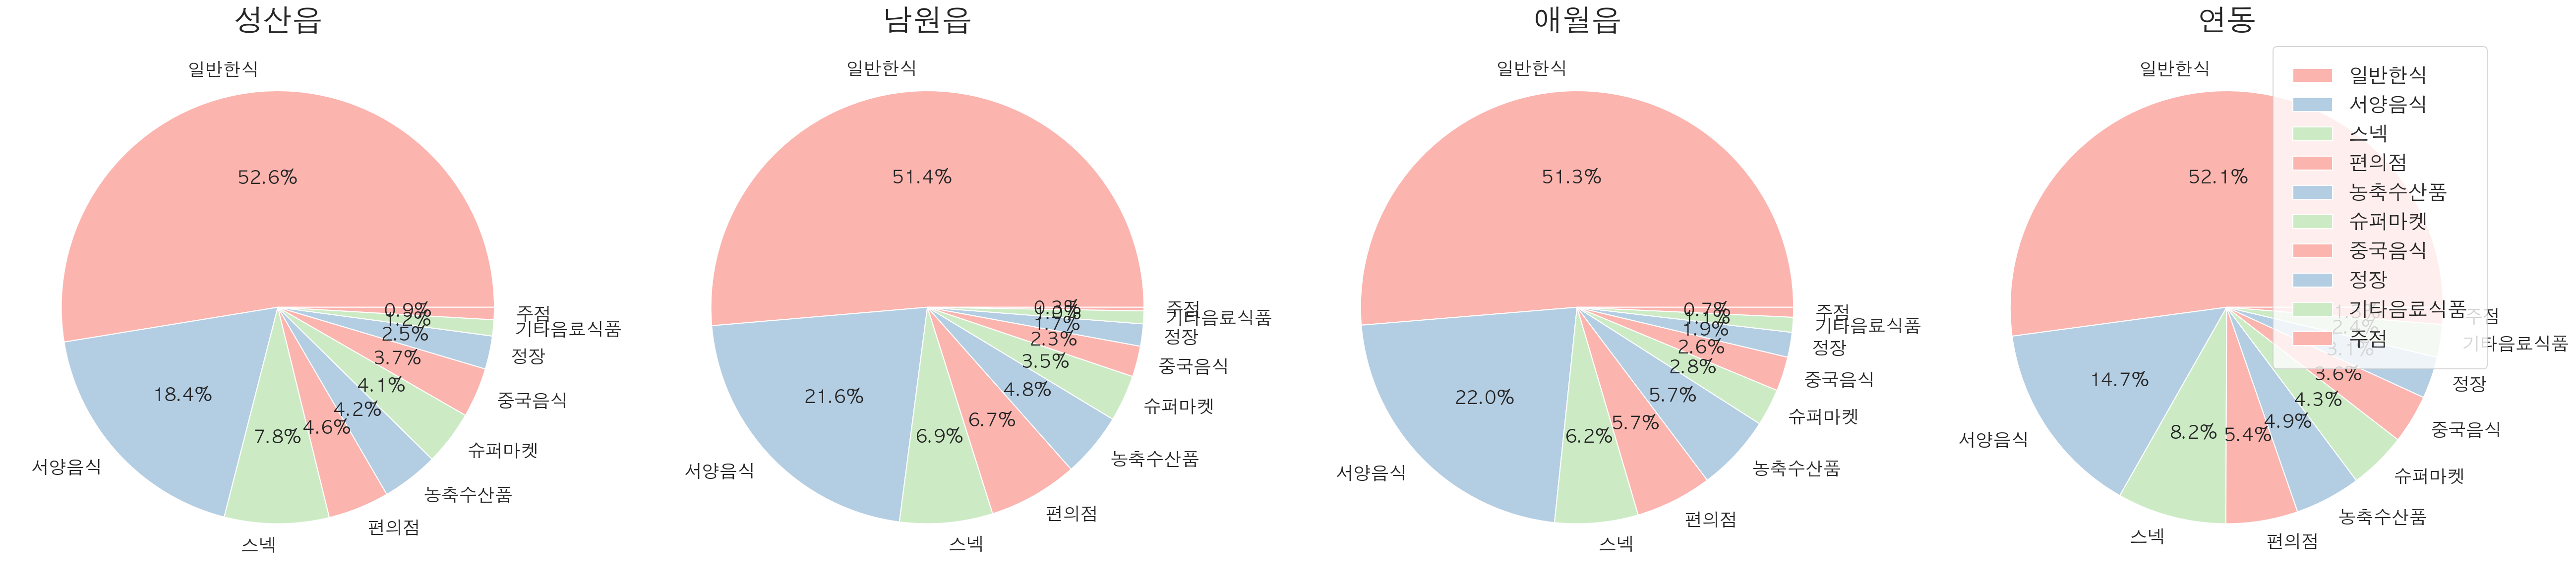

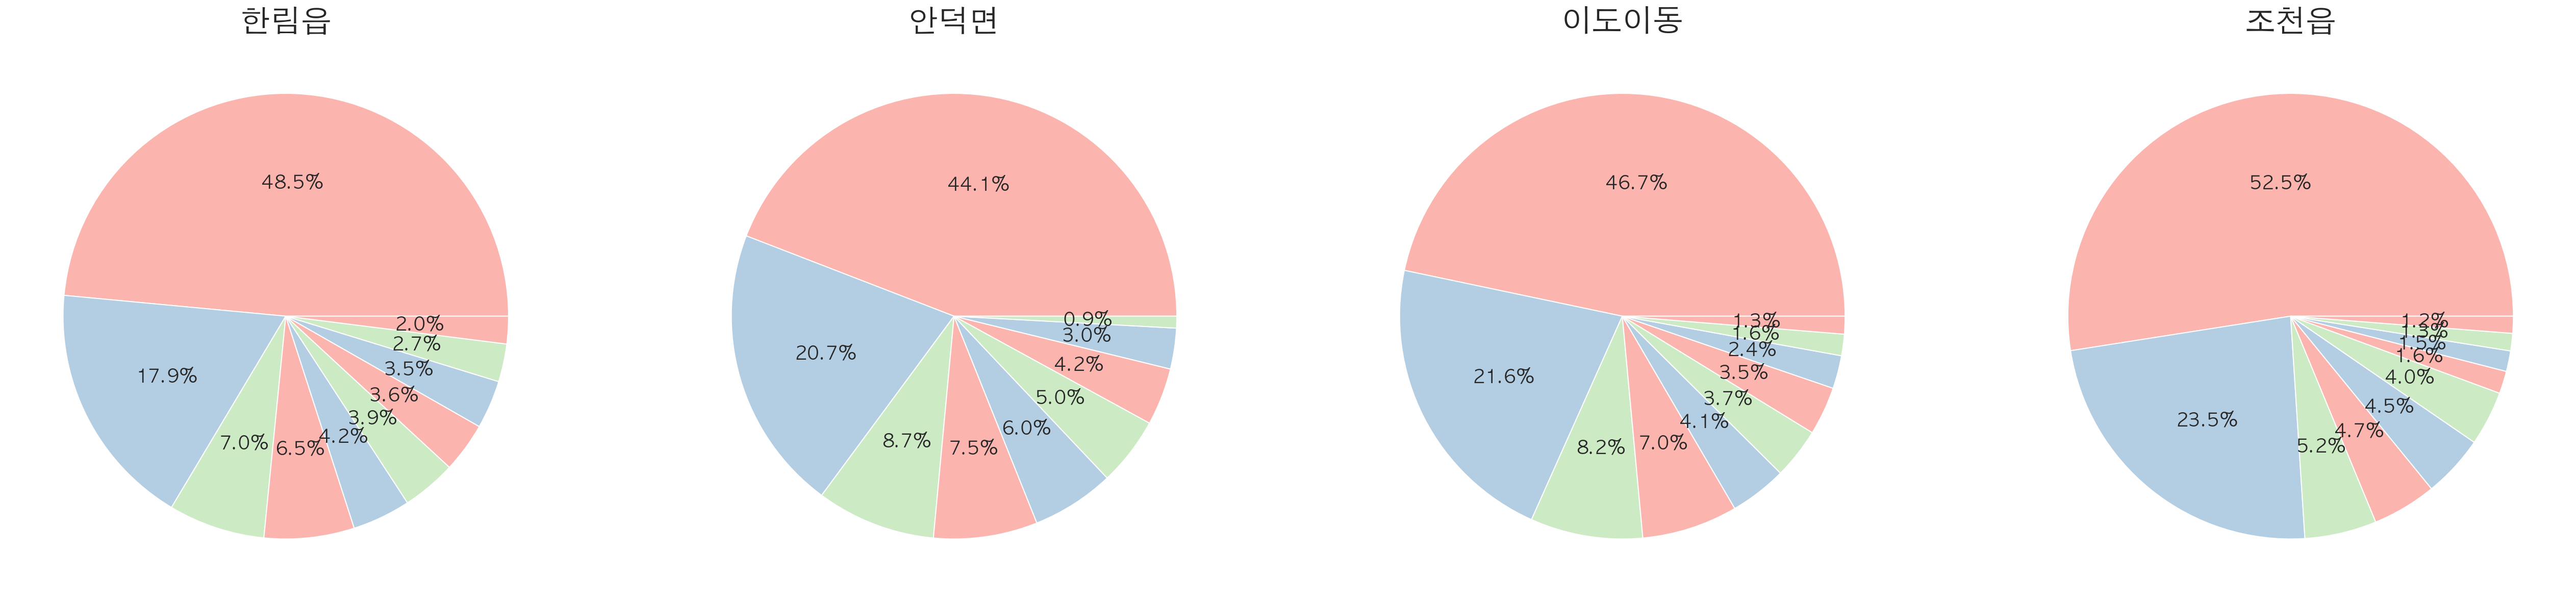

In [132]:
# 읍면동별 업종 소비 비중 비교
fig,ax = plt.subplots(1,4,figsize=(45,38))
sns.set_palette('Pastel1', 3)
lbs = type_count.index.unique().tolist()
top_dong = ['성산읍', '남원읍', '애월읍', '연동', '한림읍', '안덕면', '이도이동', '조천읍']
max_range = 4

for i in range(max_range):
    ax[i].pie(top_type_df[top_type_df['Dong'] == top_dong[i]].Type.str.split('|', expand=True).stack().value_counts(), labels=lbs, autopct='%.1f%%', textprops={'fontsize':18})
    ax[i].set_title(top_dong[i], size=30)

plt.legend(lbs,loc=1,borderpad=1, prop={'size':20})
plt.show()

fig,ax = plt.subplots(1,4,figsize=(45,38))
sns.set_palette('Pastel1', 3)

for i in range(max_range):
    ax[i].pie(top_type_df[top_type_df['Dong'] == top_dong[i+4]].Type.str.split('|', expand=True).stack().value_counts(), autopct='%.1f%%', textprops={'fontsize':18})
    ax[i].set_title(top_dong[i+4], size=30)
    
plt.show()

In [373]:
dong_sort = top_type_df.groupby(['Dong', 'Type']).sum()
dong_sort = test[['TotalSpent', 'NumofSpent']].sort_values(by='NumofSpent', ascending=False)
dong_sort

,,TotalSpent,NumofSpent
Dong,Type,,
연동,일반한식,822145278,24262
애월읍,일반한식,533904431,17174
이도이동,일반한식,506355092,16909
한림읍,일반한식,432979037,12797
조천읍,일반한식,382373900,12349
성산읍,일반한식,412752855,10842
이도이동,서양음식,122167250,9248
애월읍,서양음식,183034591,8863
연동,서양음식,117874010,8424


In [121]:
# 제주시 행정구역 .shp 파일 geopandas로 불러오기
emd = gpd.read_file("../datas/EMD_202101/TL_SCCO_EMD.shp", encoding='euc-kr')
jeju_emd = emd.loc[(emd['EMD_CD'].str.startswith('5011')|emd['EMD_CD'].str.startswith('5013'))]
jeju_emd['geometry'] = jeju_emd['geometry'].to_crs('EPSG:4326')


# top 8 읍면동 기준으로 행정구역 정리
indexlist = emd.index.tolist()
targets = []
top_dong = ['성산읍', '남원읍', '애월읍', '연동', '한림읍', '안덕면', '이도이동', '조천읍']

for i in range(len(top_dong)):
    if top_dong[i] in jeju_emd['EMD_KOR_NM'].tolist():
        target_index = jeju_emd[jeju_emd['EMD_KOR_NM'] == top_dong[i]].index.tolist()
        targets.append(target_index[0])
        
emd = emd.loc[targets]

df_numofspent = pd.DataFrame(top_type_df.groupby(['Dong'])['NumofSpent'].count())
df_numofspent

# top 8 읍면동 기준 NumofSpent
f = folium.Figure(width=800, height=400)
m = folium.Map(location = [33.363, 126.533], zoom_start= 10)
m.add_to(f)

folium.Choropleth(
            geo_data=emd, 
            data = df_numofspent['NumofSpent'],
            key_on = 'feature.properties.EMD_KOR_NM',
            columns = (df_numofspent.index, df_numofspent['NumofSpent']),
            fill_color = 'YlGn',
            fill_opacity=0.5,
            line_opacity=0.5,
            overlays = True,
            highlight=True
         ).add_to(m)

m

In [123]:
df_totalspent = pd.DataFrame(top_type_df.groupby(['Dong'])['TotalSpent'].count())
df_totalspent

# top 8 읍면동 기준 TotalSpent
f = folium.Figure(width=800, height=400)
m = folium.Map(location = [33.363, 126.533], zoom_start= 10)
m.add_to(f)

folium.Choropleth(
            geo_data=emd, 
            data = df_totalspent['TotalSpent'],
            key_on = 'feature.properties.EMD_KOR_NM',
            columns = (df_totalspent.index, df_totalspent['TotalSpent']),
            fill_color = 'YlGn',
            fill_opacity=0.5,
            line_opacity=0.5,
            overlays = True,
            highlight=True
         ).add_to(m)

m